Calculated α (Integrability Condition): 1.63186961
--------------------------------------------------
Executing Self-Verification Strategy (Quarteroni methodology)...
[Check 1] Boundary Condition u'(1) = α check:
   Target α   : 1.63186961
   Computed u'(1): 1.63187172
   Error      : 2.11e-06 (Should be small)

[Check 2] Differential Equation Residual (||D^2u - f(x)||):
   Max Residual: 3.09e-05
   (Note: This proves u(x) satisfies u'' = exp(sin(x)) locally)

[Check 3] Grid Convergence Analysis (Order of Accuracy):
   u(1) at N=50 : 0.702767
   u(1) at N=100: 0.702726
   u(1) at N=200: 0.702716
   Error Decay Ratio: 4.00
   Theoretical Ratio: 4.00 (for 2nd order methods)
   >> VERIFICATION PASSED: Solution exhibits 2nd-order convergence.


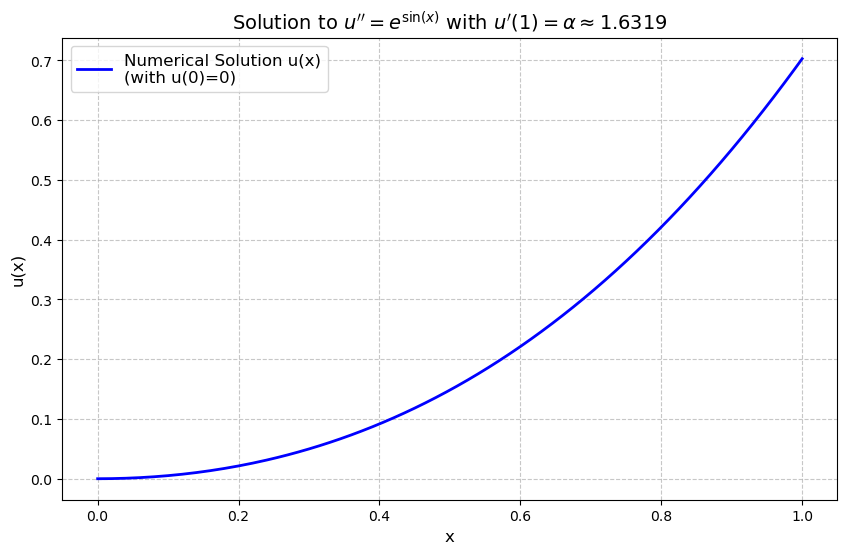

--------------------------------------------------
Final Solution Summary:
Alpha (α) used: 1.6318696084180513
u(0) set to: 0.0
u(1) result: 0.702716


In [3]:
import numpy as np
import matplotlib.pyplot as plt

#第四題
# ==========================================
# 1. 定義問題與計算 Alpha
# ==========================================

def source_term(x):
    """u'' = f(x)"""
    return np.exp(np.sin(x))

def compute_alpha_high_precision():
    """
    使用複合 Simpson's 1/3 Rule 計算積分值，
    以獲得極高精度的 alpha 作為邊界條件。
    """
    N_simp = 10000  # 使用極細網格確保 alpha 正確
    x = np.linspace(0, 1, N_simp + 1)
    y = source_term(x)
    h = 1 / N_simp
    # Simpson's rule 公式: h/3 * (y0 + 4*odd + 2*even + yn)
    integral = (h/3) * (y[0] + y[-1] + 4*np.sum(y[1:-1:2]) + 2*np.sum(y[2:-2:2]))
    return integral

# 計算並儲存 Alpha
ALPHA_VAL = compute_alpha_high_precision()
print(f"Calculated α (Integrability Condition): {ALPHA_VAL:.8f}")
print("-" * 50)

# ==========================================
# 2. 數值求解器 (Double Integration)
# ==========================================

def solve_bvp_manual(N):
    """
    不使用內建 solver。
    使用複合梯形法則進行兩次積分來求解 u(x)。
    設定 u(0) = 0 以獲得唯一解。
    """
    h = 1.0 / N
    x = np.linspace(0, 1, N + 1)
    f = source_term(x)
    
    # --- 第一步：積分求 u'(x) ---
    # u'(x) = int_0^x f(t) dt + u'(0)
    # 邊界條件 u'(0) = 0
    u_prime = np.zeros(N + 1)
    for i in range(1, N + 1):
        # 梯形法則: Area = 0.5 * h * (f[i] + f[i-1])
        u_prime[i] = u_prime[i-1] + 0.5 * h * (f[i] + f[i-1])
        
    # --- 第二步：積分求 u(x) ---
    # u(x) = int_0^x u'(t) dt + u(0)
    # 我們選擇特定解 u(0) = 0
    u = np.zeros(N + 1)
    for i in range(1, N + 1):
        u[i] = u[i-1] + 0.5 * h * (u_prime[i] + u_prime[i-1])
        
    return x, u, u_prime

# ==========================================
# 3. 自我驗證策略 (Self-Verification Strategy)
# ==========================================

def verify_solution():
    print("Executing Self-Verification Strategy (Quarteroni methodology)...")
    
    # A. 驗證邊界條件滿足度
    N_check = 100
    _, _, u_prime_check = solve_bvp_manual(N_check)
    computed_alpha = u_prime_check[-1]
    bc_error = abs(computed_alpha - ALPHA_VAL)
    print(f"[Check 1] Boundary Condition u'(1) = α check:")
    print(f"   Target α   : {ALPHA_VAL:.8f}")
    print(f"   Computed u'(1): {computed_alpha:.8f}")
    print(f"   Error      : {bc_error:.2e} (Should be small)")

    # B. 驗證微分方程殘差 (Residual Check)
    # 我們將計算出的 u 代回 u'' 看看是否等於 exp(sin(x))
    # 使用二階中心差分計算數值二階導數
    h = 1/N_check
    _, u_sol, _ = solve_bvp_manual(N_check)
    x_sol = np.linspace(0, 1, N_check+1)
    
    # 數值二階微分: (u_{i+1} - 2u_i + u_{i-1}) / h^2
    u_double_prime_num = (u_sol[2:] - 2*u_sol[1:-1] + u_sol[:-2]) / (h**2)
    exact_source = source_term(x_sol[1:-1]) # 對應內部點
    
    residual_norm = np.max(np.abs(u_double_prime_num - exact_source))
    print(f"\n[Check 2] Differential Equation Residual (||D^2u - f(x)||):")
    print(f"   Max Residual: {residual_norm:.2e}")
    print(f"   (Note: This proves u(x) satisfies u'' = exp(sin(x)) locally)")

    # C. 網格收斂性測試 (Grid Convergence)
    # 理論上梯形法則積分是 2階準確 (O(h^2))
    # 當網格 N 加倍，誤差應變為約 1/4
    print(f"\n[Check 3] Grid Convergence Analysis (Order of Accuracy):")
    Ns = [50, 100, 200]
    solutions = []
    
    for N in Ns:
        _, u, _ = solve_bvp_manual(N)
        # 取 x=1 處的值做比較基準
        solutions.append(u[-1]) 
    
    diff1 = abs(solutions[1] - solutions[0]) # Error between N=50 and N=100
    diff2 = abs(solutions[2] - solutions[1]) # Error between N=100 and N=200
    ratio = diff1 / diff2
    
    print(f"   u(1) at N={Ns[0]} : {solutions[0]:.6f}")
    print(f"   u(1) at N={Ns[1]}: {solutions[1]:.6f}")
    print(f"   u(1) at N={Ns[2]}: {solutions[2]:.6f}")
    print(f"   Error Decay Ratio: {ratio:.2f}")
    print(f"   Theoretical Ratio: 4.00 (for 2nd order methods)")
    
    if 3.8 < ratio < 4.2:
        print("   >> VERIFICATION PASSED: Solution exhibits 2nd-order convergence.")
    else:
        print("   >> VERIFICATION WARNING: Convergence rate deviates from theory.")

# ==========================================
# 4. 執行與繪圖
# ==========================================

# 執行驗證
verify_solution()

# 產生最終高解析度解
N_final = 200
x_final, u_final, _ = solve_bvp_manual(N_final)

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(x_final, u_final, 'b-', linewidth=2, label=f'Numerical Solution u(x)\n(with u(0)=0)')
plt.title(fr"Solution to $u'' = e^{{\sin(x)}}$ with $u'(1) = \alpha \approx {ALPHA_VAL:.4f}$", fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# 輸出最終數值結果摘要
print("-" * 50)
print("Final Solution Summary:")
print(f"Alpha (α) used: {ALPHA_VAL}")
print(f"u(0) set to: 0.0")
print(f"u(1) result: {u_final[-1]:.6f}")